In [1]:
import numpy as np
import scipy
from scipy.special import expit
from scipy.special import logsumexp
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer    
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import sys
sys.path.append('/home/boris/projects/aimasters/1sem/ML1/utils')
from utils import get_split, train_linear_model
storage = optuna.storages.RDBStorage("sqlite:///optuna.db")



In [2]:
data = pd.read_csv('aim-2025-callcenter/train.csv')
session_data = pd.read_csv('aim-2025-callcenter/t1_webstat.csv')
ans_data = pd.read_csv('aim-2025-callcenter/test.csv')

In [3]:
train, test = get_split(data)


In [4]:
train = train.drop('order_id', axis=1)
print(train.columns)
fetaures = train.columns[:-1]
target_col = 'is_callcenter'
print(fetaures)

Index(['create_time', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'root_id', 'model_id',
       'is_moderated', 'rating_value', 'rating_count', 'description_length',
       'goods_qty', 'pics_qty', 'model_create_time', 'is_callcenter'],
      dtype='object')
Index(['create_time', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'root_id', 'model_id',
       'is_moderated', 'rating_value', 'rating_count', 'description_length',
       'goods_qty', 'pics_qty', 'model_create_time'],
      dtype='object')


In [ ]:
model, logreg_features, scaler =  train_linear_model(train, features = fetaures, target_col = target_col)


In [8]:
X_tr = train[fetaures].to_numpy()
y_tr = train[target_col].to_numpy()

In [15]:
def objectiveSklearn(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    l1_ratio = None
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga']) 
    if penalty == 'l1' and solver == 'lbfgs':
        raise optuna.TrialPruned()
    clf = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        tol=tol,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
        random_state=42
    )
    
    clf.fit(X_tr, y_tr)
    return -roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])

study = optuna.create_study(storage=storage)

[I 2025-11-01 14:34:46,281] A new study created in RDB with name: no-name-2afa7df2-a90d-4294-a9ee-fe6dc8de9745


In [20]:
clf = LogisticRegression(    )
    
clf.fit(X_tr, y_tr)

ValueError: could not convert string to float: '1976-01-27 19:24:36'

In [17]:
study.optimize(objectiveSklearn, n_trials=10)

study.best_params 

[W 2025-11-01 14:34:55,145] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 0.015175738137397182, 'tol': 1.509033498638537e-05, 'max_iter': 139, 'solver': 'liblinear'} because of the following error: ValueError("could not convert string to float: '1976-01-27 19:24:36'").
Traceback (most recent call last):
  File "/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_50073/2316840530.py", line 20, in objectiveSklearn
    clf.fit(X_tr, y_tr)
    ~~~~~~~^^^^^^^^^^^^
  File "/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py", line 1247, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^

ValueError: could not convert string to float: '1976-01-27 19:24:36'

In [6]:
weights = model.coef_[0]
feature_names = logreg_features
feature_weights = pd.DataFrame({
    'feature': feature_names,
    'weight': weights,
    'abs_weight': np.abs(weights)
})
top_k = 10
top_features = feature_weights.nlargest(top_k, 'abs_weight')

In [19]:
df_test = pd.DataFrame({'time': [pd.to_datetime('2019-01-15 13:25:43')]})
df_unix_sec = pd.to_datetime(df_test['time']).astype(int)/ 10**9
print(df_unix_sec)

0    1.547559e+09
Name: time, dtype: float64


/tmp/ipykernel_50073/2456173529.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


[Text(0, 0, 'price'),
 Text(1, 0, 'utm_medium'),
 Text(2, 0, 'category_id'),
 Text(3, 0, 'good_id'),
 Text(4, 0, 'model_id'),
 Text(5, 0, 'pics_qty'),
 Text(6, 0, 'goods_qty'),
 Text(7, 0, 'is_moderated'),
 Text(8, 0, 'root_id'),
 Text(9, 0, 'description_length')]

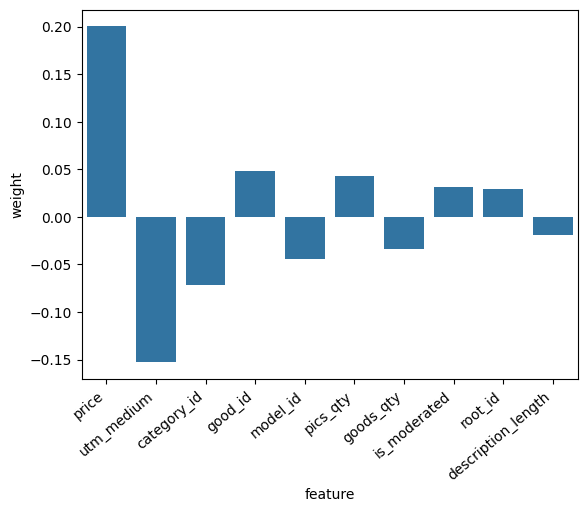

In [7]:
ax = sns.barplot(data=top_features, x='feature', y = 'weight')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")